# グラフ可視化
エンティティ間の関係をグラフとして表示します。
同じ memory_unit に紐づくエンティティ同士をリンクとして描画します。

In [1]:
import psycopg2
import networkx as nx
from pyvis.network import Network
from collections import defaultdict

conn = psycopg2.connect(host="db", dbname="myfriend", user="postgres", password="postgres")
cur = conn.cursor()

In [2]:
# エンティティ一覧
cur.execute("""
    SELECT id, canonical_name, entity_type, mention_count
    FROM entities
    ORDER BY mention_count DESC
""")
entities = cur.fetchall()
print(f"{len(entities)} 件のエンティティ")
for e in entities[:20]:
    print(f"  {e[1]} ({e[2]}) - {e[3]} mentions")

3 件のエンティティ
  Murasaki Shikibu (person) - 3 mentions
  ユーザー (person) - 3 mentions
  ユーザーさん (person) - 1 mentions


In [3]:
# エンティティ間の共起関係を取得
# 同じ memory_unit に紐づくエンティティ同士 = 関連がある
cur.execute("""
    SELECT
        e1.canonical_name AS entity1,
        e1.entity_type AS type1,
        e2.canonical_name AS entity2,
        e2.entity_type AS type2,
        COUNT(*) AS co_occurrence,
        ARRAY_AGG(DISTINCT LEFT(mu.text, 60)) AS sample_facts
    FROM unit_entities ue1
    JOIN unit_entities ue2 ON ue1.unit_id = ue2.unit_id AND ue1.entity_id < ue2.entity_id
    JOIN entities e1 ON ue1.entity_id = e1.id
    JOIN entities e2 ON ue2.entity_id = e2.id
    JOIN memory_units mu ON ue1.unit_id = mu.id
    GROUP BY e1.canonical_name, e1.entity_type, e2.canonical_name, e2.entity_type
    ORDER BY co_occurrence DESC
""")
edges = cur.fetchall()
print(f"{len(edges)} 件の関係")
for edge in edges[:10]:
    print(f"  {edge[0]} <-> {edge[2]} ({edge[4]} 回共起)")

0 件の関係


In [4]:
# NetworkX グラフを構築
G = nx.Graph()

type_colors = {
    'person': '#FF6B6B',
    'organization': '#4ECDC4',
    'location': '#45B7D1',
    'concept': '#96CEB4',
    'event': '#FFEAA7',
    'other': '#DDA0DD'
}

# ノード追加
for e in entities:
    G.add_node(e[1], entity_type=e[2], mentions=e[3],
               color=type_colors.get(e[2], '#DDA0DD'),
               size=10 + e[3] * 3)

# エッジ追加
for edge in edges:
    G.add_edge(edge[0], edge[2], weight=edge[4],
               title=f"{edge[4]}回共起\n" + '\n'.join(edge[5][:3]))

print(f"ノード: {G.number_of_nodes()}, エッジ: {G.number_of_edges()}")

ノード: 3, エッジ: 0


In [5]:
# pyvis でインタラクティブグラフを表示
if G.number_of_nodes() > 0:
    net = Network(notebook=True, height='600px', width='100%', cdn_resources='in_line')
    net.from_nx(G)
    net.toggle_physics(True)
    net.show('entity_graph.html')
else:
    print("エンティティがありません。まず記憶を保存してください。")

entity_graph.html


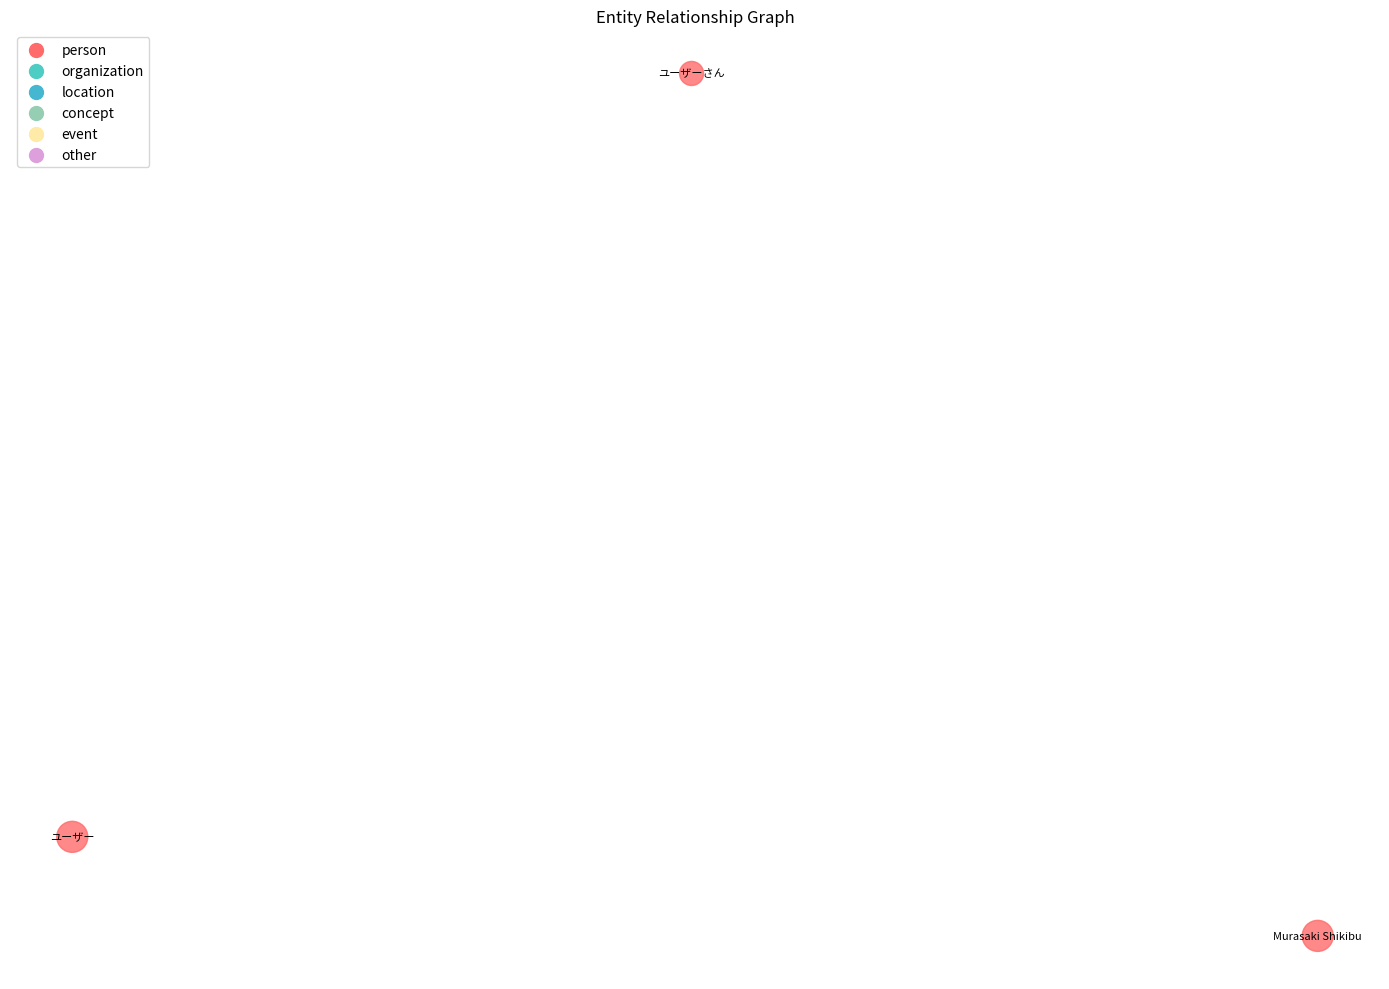

In [6]:
# matplotlib でも表示（静的）
if G.number_of_nodes() > 0:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=2, iterations=50)

    node_colors = [type_colors.get(G.nodes[n].get('entity_type', 'other'), '#DDA0DD') for n in G.nodes()]
    node_sizes = [G.nodes[n].get('mentions', 1) * 100 + 200 for n in G.nodes()]
    edge_widths = [G.edges[e].get('weight', 1) for e in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # 凡例
    for label, color in type_colors.items():
        plt.scatter([], [], c=color, label=label, s=100)
    plt.legend(loc='upper left')
    plt.title('Entity Relationship Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
cur.close()
conn.close()
print("接続を閉じました")

接続を閉じました
